In [1]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from paper_visualizations import * 
from PixelEM import * 
# from test_sample import test_sample_obj
import json

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [90]:
df = pd.read_csv("pixel_em/MV_PRJ_table.csv")
df = df.rename(columns={"MV_precision":"P [MV]",
                       "MV_recall":"R [MV]",
                       "MV_jaccard":"J [MV]"})
# for mode in  ["GT","isoGT","GTLSA","isoGTLSA","basic"]:
#     data =  pd.read_csv("pixel_em/{}_ground_truth_full_PRJ_table.csv".format(mode))
#     data = data.rename(columns={"EM_precision":"P [{}]".format(mode),
#                        "EM_recall":"R [{}]".format(mode),
#                        "EM_jaccard":"J [{}]".format(mode),})
#     df = df.merge(data)

In [93]:
MV = pkl.load(open("pixel_em/5workers_rand7/obj7/MV_mask.pkl"))

In [103]:
objid=7
gt= get_gt_mask(objid)


In [102]:
faster_compute_prj?

In [104]:
[p, r, j] = faster_compute_prj(MV,gt)
p,r,j

(0.861904761904762, 0.6040044493882091, 0.550709939148073)

In [109]:
def compute_PRJ_MV(sample_name, objid, mode=""):
    outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
    MV_mask = pickle.load(open('{}MV_mask.pkl'.format(outdir)))
    # Computing MV PRJ against Ground Truth
    gt = get_gt_mask(objid)
    [p, r, j] = faster_compute_prj(MV_mask,gt)
    with open('{}MV_prj.json'.format(outdir), 'w') as fp:
        fp.write(json.dumps([p, r,j]))
    return p,r,j

In [110]:
compute_PRJ_MV("5workers_rand7",10)

(0.9639148343679295, 0.9849427944750726, 0.9499171002229718)

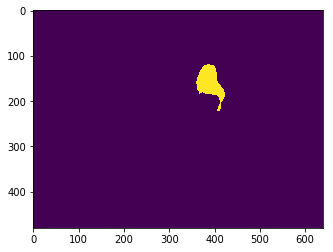

In [95]:
plt.imshow(MV)

In [92]:
df[(df["num_workers"]==5)&(df["sample_num"]==7)]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV]
188,5,7,1,0.988346,0.971662,0.960655
189,5,7,2,0.951493,0.980928,0.934211
190,5,7,3,0.967181,0.905462,0.878471
191,5,7,4,0.926829,0.921212,0.858757
192,5,7,5,0.973224,0.879723,0.858934
193,5,7,6,0.889189,0.941345,0.842510
194,5,7,7,NaN,NaN,NaN
195,5,7,8,NaN,NaN,NaN
196,5,7,9,NaN,NaN,NaN
197,5,7,10,NaN,NaN,NaN


In [78]:
metric_keys=[u'P [MV]',u'R [MV]', u'J [MV]', u'P [GT]', u'R [GT]', u'J [GT]', u'P [isoGT]',
       u'R [isoGT]', u'J [isoGT]', u'P [GTLSA]', u'R [GTLSA]', u'J [GTLSA]',
       u'P [isoGTLSA]', u'R [isoGTLSA]', u'J [isoGTLSA]', u'P [basic]',
       u'R [basic]', u'J [basic]']

Extracting important clusters only

In [79]:
cluster_df  = pd.read_csv("spectral_clustering_all_hard_obj.csv")

In [80]:
filtered_algo_df = df[df["clust"].isin([0,-1])]

In [81]:
df["J [avrg]"]=df[metric_J].mean(axis=1)

- J [GTLSA] is doing very badly

In [71]:
df["objclust"]=1

df.groupby(['objid','clust']).apply(lambda x:x["objclust"].reset_index()).reset_index()

In [73]:
df.groupby(['objid','clust']).apply(lambda x:x["objclust"].reset_index()).reset_index()

,objid,clust,level_2,index,objclust
0,1,-1,0,10,1
1,1,-1,1,11,1
2,1,-1,2,12,1
3,1,-1,3,13,1
4,1,-1,4,14,1
5,1,-1,5,495,1
6,1,-1,6,496,1
7,1,-1,7,497,1
8,1,-1,8,498,1
9,1,-1,9,499,1


,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,clust,P [GT],R [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [avrg]
2050,5,7,12,NaN,NaN,NaN,-4,-1,1,1,...,1,1,1,1,1,1,1,1,1,1
2051,5,7,12,NaN,NaN,NaN,-2,-1,1,1,...,1,1,1,1,1,1,1,1,1,1
2052,5,7,12,NaN,NaN,NaN,0,-1,1,1,...,1,1,1,1,1,1,1,1,1,1
2053,5,7,12,NaN,NaN,NaN,2,-1,1,1,...,1,1,1,1,1,1,1,1,1,1
2054,5,7,12,NaN,NaN,NaN,4,-1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [87]:
df.loc[df.groupby(['objid','clust'])["J [avrg]"].idxmax()]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,clust,P [GT],R [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [avrg]
12623,20,2,1,0.988234,0.978384,0.967118,2,-1,0.978005,0.988352,...,0.986408,0.983960,0.970798,0.986257,0.983960,0.970651,0.988243,0.979109,0.967836,0.968986
14068,25,0,1,0.986239,0.979873,0.966657,2,0,0.977215,0.990987,...,0.984305,0.986786,0.971499,0.984379,0.986709,0.971497,0.985368,0.985029,0.970828,0.969337
2433,5,4,1,0.985039,0.978155,0.963835,2,1,0.911623,0.195005,...,0.911454,0.194203,0.190606,0.995598,0.932974,0.929142,0.980804,0.187328,0.186644,0.565113
5838,5,3,2,0.959761,0.988587,0.949243,2,-1,0.959761,0.988587,...,0.979925,0.974921,0.955830,0.977511,0.979126,0.957556,0.959761,0.988587,0.949243,0.953112
4388,10,6,3,0.962689,0.921481,0.889706,2,-1,0.936847,0.966124,...,0.980802,0.898897,0.883355,0.976654,0.922794,0.902878,0.962730,0.922532,0.890720,0.896461
11193,10,7,4,0.945301,0.947879,0.898592,2,-1,0.916880,0.976061,...,0.980361,0.922727,0.905980,0.976050,0.950909,0.929227,0.945743,0.956061,0.906349,0.909009
14579,25,1,4,0.946526,0.949394,0.901064,4,0,0.919691,0.975152,...,0.963168,0.950909,0.917544,0.962929,0.952424,0.918737,0.956098,0.950303,0.910569,0.908569
3428,5,2,4,0.951036,0.959394,0.914236,2,1,0.447770,0.924848,...,0.447770,0.924848,0.432050,0.982367,0.877879,0.864260,0.447770,0.924848,0.432050,0.655987
1013,5,9,5,NaN,NaN,NaN,2,-1,0.936025,0.950358,...,0.963293,0.907385,0.877059,0.977608,0.884169,0.866618,0.955721,0.922203,0.884415,0.876112
9748,10,4,6,0.946221,0.931330,0.884511,2,-1,0.862547,0.978541,...,0.962519,0.918455,0.886740,0.962519,0.918455,0.886740,0.946221,0.931330,0.884511,0.879296


In [83]:
# df.groupby(['objid','clust']).apply(lambda x:x["objclust"].reset_index()).reset_index()

In [13]:
filtered_algo_df[filtered_algo_df["thresh"]==0].mean()[metric_keys]

P [MV]          0.944792
R [MV]          0.925714
J [MV]          0.877141
P [GT]          0.870233
R [GT]          0.961227
J [GT]          0.840099
P [isoGT]       0.914184
R [isoGT]       0.946721
J [isoGT]       0.869288
P [GTLSA]       0.287064
R [GTLSA]       0.951911
J [GTLSA]       0.282240
P [isoGTLSA]    0.883461
R [isoGTLSA]    0.949199
J [isoGTLSA]    0.841767
P [basic]       0.895915
R [basic]       0.932698
J [basic]       0.838190
dtype: float64

### Performance as it varies with number of workers

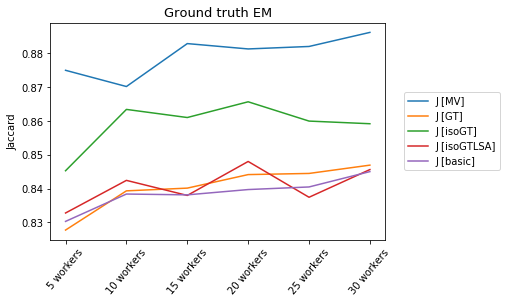

In [14]:
Nworker_performance = filtered_algo_df.groupby("num_workers").mean()
MVarr = np.array(Nworker_performance["J [MV]"])
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM",fontsize=13)

In [12]:
def plot_PRcurve(objid,num_worker,sample_num=0):
    objdf = df[(df["num_workers"]==num_worker)&(df["sample_num"]==sample_num)&(df["objid"]==objid)]
    plt.figure()
    for algo in ['basic','GT','isoGT','GTLSA','isoGTLSA']:
        x= objdf["P [{}]".format(algo)]
        y = objdf["R [{}]".format(algo)]
        if len(x)<=0:
            return
        sortedx, sortedy = zip(*sorted(zip(x, y)))
        plt.plot(sortedx,sortedy,'.-',label=algo)
    plt.xlabel("Precision",fontsize=13)
    plt.ylabel("Recall",fontsize=13)
    plt.legend(loc="bottom left")
    plt.title("{}worker_rand{} [obj {};N={}]".format(num_worker,sample_num,objid,len(objdf)))

# Greedy Algo Results

In [42]:
from glob import glob 
import pandas as pd

globfnames = glob("withClust_greedy_result_*.csv")
globfnames.remove('withClust_greedy_result_worker_fraction.csv')
greedy_df = pd.read_csv(globfnames[0],index_col=0)
for fname in globfnames[1:]: 
    greedy_df = greedy_df.append(pd.read_csv(fname,index_col=0))

# assert len(greedy_df)==31*44*5

greedy_df.to_csv("withClust_all_greedy_result.csv")

In [35]:
greedy_df = pd.read_csv("withClust_all_greedy_result.csv",index_col=0)

# ground_truth_greedy_df = pd.read_csv("ground_truth_greedy_result.csv")
# greedy_df = greedy_df.append(ground_truth_greedy_df)
worker_frac_greedy_df = pd.read_csv("withClust_greedy_result_worker_fraction.csv")
greedy_df = greedy_df.append(worker_frac_greedy_df)

#greedy_df["num_workers"] = greedy_df["sample"].apply(lambda x: int(x.split("workers")[0]))

In [44]:
!head withClust_greedy_result_1.csv

,sample,objid,algo,cluster_id,p,r,j
0,5workers_rand8,1,basic,cluster_id,0.985888884605,0.976588756493,0.963126177024
1,5workers_rand8,1,GT,cluster_id,0.965294052003,0.99106324473,0.956964265959
2,5workers_rand8,1,isoGT,cluster_id,0.986019387479,0.975061106019,0.961764484291
3,5workers_rand8,1,GTLSA,cluster_id,0.981344733774,0.964329361442,0.94696969697
4,5workers_rand8,1,isoGTLSA,cluster_id,0.983566716815,0.973762603116,0.95817361894
5,5workers_rand8,1,basic,cluster_id,0.985888884605,0.976588756493,0.963126177024
6,5workers_rand8,1,GT,cluster_id,0.965294052003,0.99106324473,0.956964265959
7,5workers_rand8,1,isoGT,cluster_id,0.986019387479,0.975061106019,0.961764484291
8,5workers_rand8,1,GTLSA,cluster_id,0.981344733774,0.964329361442,0.94696969697


In [43]:
greedy_df.head()

,sample,objid,algo,cluster_id,p,r,j
0,5workers_rand8,1,basic,cluster_id,0.985889,0.976589,0.963126
1,5workers_rand8,1,GT,cluster_id,0.965294,0.991063,0.956964
2,5workers_rand8,1,isoGT,cluster_id,0.986019,0.975061,0.961764
3,5workers_rand8,1,GTLSA,cluster_id,0.981345,0.964329,0.946970
4,5workers_rand8,1,isoGTLSA,cluster_id,0.983567,0.973763,0.958174


In [32]:
worker_frac_greedy_df.head()

,sample,objid,algo,cluster_id,p,r,j
0,25workers_rand0,1,worker fraction,0,0.984171,0.985411,0.970036
1,25workers_rand0,1,worker fraction,1,0.980804,0.187328,0.186644
2,25workers_rand0,4,worker fraction,0,0.942394,0.951818,0.899485
3,25workers_rand0,4,worker fraction,1,0.447770,0.924848,0.432050
4,25workers_rand0,7,worker fraction,0,0.889672,0.561513,0.524958


In [22]:
!head withClust_greedy_result_1.csv

,sample,objid,algo,cluster_id,p,r,j
0,5workers_rand8,1,basic,cluster_id,0.985888884605,0.976588756493,0.963126177024
1,5workers_rand8,1,GT,cluster_id,0.965294052003,0.99106324473,0.956964265959
2,5workers_rand8,1,isoGT,cluster_id,0.986019387479,0.975061106019,0.961764484291
3,5workers_rand8,1,GTLSA,cluster_id,0.981344733774,0.964329361442,0.94696969697
4,5workers_rand8,1,isoGTLSA,cluster_id,0.983566716815,0.973762603116,0.95817361894
5,5workers_rand8,1,basic,cluster_id,0.985888884605,0.976588756493,0.963126177024
6,5workers_rand8,1,GT,cluster_id,0.965294052003,0.99106324473,0.956964265959
7,5workers_rand8,1,isoGT,cluster_id,0.986019387479,0.975061106019,0.961764484291
8,5workers_rand8,1,GTLSA,cluster_id,0.981344733774,0.964329361442,0.94696969697


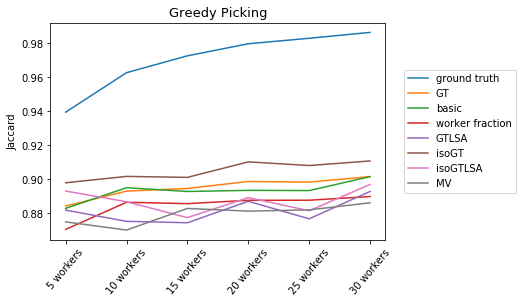

In [18]:
Nworker_performance = greedy_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [19]:
greedy_df[(greedy_df["sample"]=="30workers_rand0")&(greedy_df["objid"]==7)]

,sample,objid,algo,p,r,j,num_workers
30,30workers_rand0,7,basic,0.888850,0.571079,0.533015,30
31,30workers_rand0,7,GT,0.883962,0.949055,0.843917,30
32,30workers_rand0,7,isoGT,0.936327,0.932369,0.876778,30
33,30workers_rand0,7,GTLSA,0.928919,0.848943,0.797159,30
34,30workers_rand0,7,isoGTLSA,0.943166,0.930367,0.880977,30
1018,30workers_rand0,7,ground truth,0.986317,0.978198,0.965101,30
1018,30workers_rand0,7,worker fraction,0.882112,0.575973,0.534807,30


This is interesting, the object performed badly with basic and worker fraction but advacned methods resolved this

In [54]:
greedy_df[(greedy_df["j"]<0.7)&(greedy_df["num_workers"]==30)]

,sample,objid,algo,p,r,j,num_workers
30,30workers_rand0,7,basic,0.888850,0.571079,0.533015,30
138,30workers_rand0,28,GTLSA,0.256703,0.955701,0.253684,30
139,30workers_rand0,28,isoGTLSA,0.257111,0.963182,0.254608,30
1018,30workers_rand0,7,worker fraction,0.882112,0.575973,0.534807,30
1026,30workers_rand0,15,worker fraction,0.681879,1.000000,0.681879,30


# Picking out poorly performing objects from Greedy EM 

Things that fail with GTLSA 

In [22]:
df["J [GTLSA-MV]"]=df["J [GTLSA]"]-df["J [MV]"]
df["J [GTLSA-MV]"] = df["J [GTLSA-MV]"].abs()

In [37]:
df[(df["num_workers"]>20)&(df["J [GTLSA-MV]"]>0.5)].head()

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6170,30,0,3,0.962144,0.914391,0.882636,-4,0.934359,0.956933,0.896654,...,0.011386,0.915441,0.011374,0.961830,0.933036,0.899721,0.960418,0.917542,0.884109,0.871263
6171,30,0,3,0.962144,0.914391,0.882636,-2,0.934582,0.956670,0.896628,...,0.011353,0.912815,0.011341,0.962701,0.928571,0.896324,0.961168,0.916492,0.883768,0.871295
6172,30,0,3,0.962144,0.914391,0.882636,0,0.934515,0.955620,0.895644,...,0.011312,0.909401,0.011299,0.967813,0.923845,0.896306,0.961942,0.915966,0.883933,0.871337
6175,30,0,4,0.944882,0.945455,0.896037,-4,0.910654,0.979091,0.893282,...,0.010244,0.939394,0.010237,0.935834,0.967879,0.907644,0.944813,0.949394,0.899512,0.885800
6176,30,0,4,0.944882,0.945455,0.896037,-2,0.912048,0.977273,0.893104,...,0.010211,0.936364,0.010204,0.938421,0.965152,0.907666,0.944780,0.948788,0.898938,0.885832


It seems like for this case the GTLSA is failing because of some thresholds 

In [40]:
df[(df["num_workers"]==30)&(df["sample_num"]==0)&(df["objid"]==3)]#["J [GTLSA]"]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6170,30,0,3,0.962144,0.914391,0.882636,-4,0.934359,0.956933,0.896654,...,0.011386,0.915441,0.011374,0.961830,0.933036,0.899721,0.960418,0.917542,0.884109,0.871263
6171,30,0,3,0.962144,0.914391,0.882636,-2,0.934582,0.956670,0.896628,...,0.011353,0.912815,0.011341,0.962701,0.928571,0.896324,0.961168,0.916492,0.883768,0.871295
6172,30,0,3,0.962144,0.914391,0.882636,0,0.934515,0.955620,0.895644,...,0.011312,0.909401,0.011299,0.967813,0.923845,0.896306,0.961942,0.915966,0.883933,0.871337
6173,30,0,3,0.962144,0.914391,0.882636,2,0.934447,0.954569,0.894659,...,0.977740,0.899685,0.881626,0.971706,0.919905,0.895908,0.962207,0.915966,0.884157,0.001010
6174,30,0,3,0.962144,0.914391,0.882636,4,0.939425,0.952994,0.897823,...,0.978516,0.897059,0.879732,0.972920,0.915179,0.892446,0.962176,0.915179,0.883397,0.002904


In [41]:
df[(df["num_workers"]==30)&(df["sample_num"]==0)&(df["objid"]==4)]#["J [GTLSA]"]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6175,30,0,4,0.944882,0.945455,0.896037,-4,0.910654,0.979091,0.893282,...,0.010244,0.939394,0.010237,0.935834,0.967879,0.907644,0.944813,0.949394,0.899512,0.885800
6176,30,0,4,0.944882,0.945455,0.896037,-2,0.912048,0.977273,0.893104,...,0.010211,0.936364,0.010204,0.938421,0.965152,0.907666,0.944780,0.948788,0.898938,0.885832
6177,30,0,4,0.944882,0.945455,0.896037,0,0.914845,0.976667,0.895278,...,0.010195,0.934848,0.010188,0.943520,0.961818,0.909456,0.945048,0.948485,0.898909,0.885849
6178,30,0,4,0.944882,0.945455,0.896037,2,0.916927,0.976667,0.897272,...,0.963636,0.931515,0.899883,0.946707,0.958182,0.909143,0.945015,0.947879,0.898334,0.003846
6179,30,0,4,0.944882,0.945455,0.896037,4,0.916856,0.975758,0.896437,...,0.966214,0.927273,0.898151,0.951705,0.955455,0.911272,0.946412,0.947273,0.899051,0.002114


same with this one

# What is the performance if we only pick easy objects? 

In [76]:
# Task difficulty
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
type_one_task_ambiguity = [15,20,22,27,31,40,41,42,47] #wrong object annotation
type_two_task_ambiguity = [1,4,7,8,9,10,18,20,21,25,28,29,30,31,32,33,34,35] #missing region


small_area = [1,15,22]
high_numPts=[5,7,9,10,11,12,28,29,30,37]
all_hard_tasks = list(set(np.concatenate((type_one_task_ambiguity,type_two_task_ambiguity))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]

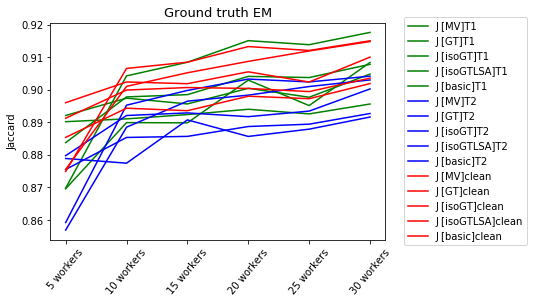

In [81]:
Nworker_performance = df[~df["objid"].isin(type_one_task_ambiguity)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"T1",color="green")
        

Nworker_performance = df[~df["objid"].isin(type_two_task_ambiguity)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"T2",color="blue")
        
Nworker_performance = df[df["objid"].isin(easy_tasks)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"clean",color="red")

plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM",fontsize=13)

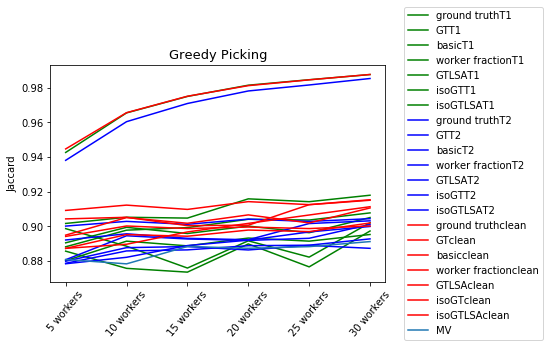

In [80]:
Nworker_performance = greedy_df[~greedy_df["objid"].isin(type_one_task_ambiguity)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"T1",color="green")
#
Nworker_performance = greedy_df[~greedy_df["objid"].isin(type_two_task_ambiguity)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"T2",color="blue")
#
Nworker_performance = greedy_df[greedy_df["objid"].isin(easy_tasks)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"clean",color="red")
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [73]:
len(easy_tasks)

41

In [74]:
len(object_lst)

44